<a href="https://colab.research.google.com/github/Jibrangit/DL_Assignments/blob/Experiment/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [163]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as Func
import scipy

In [164]:
INPUT = 784
HIDDEN = 200
BATCH_SIZE = 100
NUM_EPOCHS = 100

In [165]:
class Encoder (nn.Module):    
  def __init__ (self):        
    super(Encoder, self).__init__()        # TODO initialize layers 
    self.hidden = nn.Linear(784, HIDDEN) 
    self.output = nn.Linear(HIDDEN, 32)   
    self.dropout = nn.Dropout()
    self.activation = nn.Tanh() 
    # self.positive = nn.Sigmoid()  
    self.flatten = nn.Flatten()
    
  def forward (self, X):        
      # TODO execute layers and return result 
      X = self.flatten(X)
      X = self.activation(X)
      X = self.dropout(X)
      X = self.hidden(X)
      X = self.activation(X)
      X = self.dropout(X)
      MU = self.output(X)   
      SIGMA2 = self.output(X)   
      SIGMA2 = torch.square(SIGMA2)
      
      return MU, SIGMA2

class Decoder (nn.Module):    
  def __init__ (self):        
    super(Decoder, self).__init__()        
    # TODO initialize layers
    self.hidden = nn.Linear(32, HIDDEN) 
    self.output = nn.Linear(HIDDEN, 784)   
    self.dropout = nn.Dropout()
    self.activation = nn.Tanh()   
    self.sigmoid_output = nn.Sigmoid()    
  
  def forward (self, Z):        
    # TODO execute layers and return result 
    Z = self.hidden(Z)
    Z = self.activation(Z)
    Z = self.dropout(Z)
    Z = self.output(Z)   
    Z = self.sigmoid_output(Z)    
    
    
    return Z

class VAE (nn.Module):    
  def __init__ (self):        
    super(VAE, self).__init__()        
    self.decoder = Decoder()        
    self.encoder = Encoder()

# Computes the hidden representation given the pre-sampled values eps    
  def latent_code (self, x):        
    mu, sigma2 = self.encoder(x)    
    # TODO extract mu and sigma2 from the code, and then use them and eps        
    # to compute z.
    sigma = torch.sqrt(sigma2) 
    epsilon = torch.LongTensor(scipy.random.normal(0, 1, sigma.shape[1]))
    # print(sigma.shape)
    z =  mu.mul(epsilon) + sigma


    return z, mu, sigma2


  def recon_x (self, z):        
     x = self.decoder(z)        
     return x

def train (device, vae, x):
  optimizer = optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)

  losses = []
  def computeLoss (x): 
    # TODO implement your custom loss 
    z, mu, sigma2 = vae.latent_code(x)
    reconstructed_x = vae.recon_x(z)
    # print(f' reconstructed x is: {reconstructed_x[0]}')
    # print(f' x is: {x[0]}')
    # print(f'Shapes of x and reconstructed x are: {x.shape} and {reconstructed_x.shape}')

    BCE =  Func.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    # KLD = -0.5 * torch.sum(1 + torch.log(sigma2) - mu.pow(2) - sigma2.pow(2))
    KLD = 0

    Total_loss = BCE + KLD
    return Total_loss, z

  for e in range(NUM_EPOCHS):
    if e%10 == 0:
      print("Epoch: {}".format(e))
    for i in np.arange(0, len(X), BATCH_SIZE):
      # Call computeLoss on each minibatch
      miniBatch = X[i*BATCH_SIZE : (i+1)*BATCH_SIZE]
      loss, z = computeLoss(miniBatch)         
      loss.backward()            
      optimizer.step()    

Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90


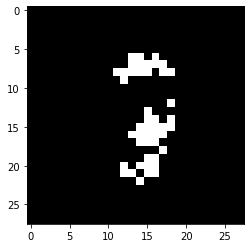

In [166]:
if __name__ == "__main__":    
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
  vae = VAE().to(device)    
  X = torch.from_numpy(np.load("/content/drive/MyDrive/Colab Notebooks/DL_Assignments/HW7/mnist_train_images.npy")).float().to(device)   
  # print(X.shape) 
  train(device, vae, X)

  # z_sample = vae.encoder.forward(X[0:16])
  # z_sample = torch.LongTensor(z_sample)
  # recon_x_sample = vae.decoder(z_sample)
  # print(recon_x.sample.shape)

import matplotlib.pyplot as plt

with torch.no_grad():
    z = torch.randn(32)
    sample = vae.decoder(z)
    
    Z = sample.reshape([28, 28])
    plt.imshow(Z, cmap="gray")


